In [1]:
import sys
sys.path.append('/home/nick/projects')
# from PointGPT import segmentation
from SMF_public.loader import FinDataset
import numpy as np
import pandas as pd
import os
from glob2 import glob
import plotly.express as px
import plotly.graph_objects as go
import torch
from src.utilities.functions import path_leaf
from tqdm import tqdm

In [2]:
frame_metadata_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/metadata/"
master_df = pd.read_csv(frame_metadata_root + "master_metadata.csv")

In [3]:
from sklearn.neighbors import KernelDensity
from src.utilities.fin_class_def import FinData
from alphashape import alphashape

n_sample_points = 1024
alpha = 10

# load fin objects. Keep only those that have been approved
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
seg_type = "tissue_only_best_model_tissue"
fin_object_path = os.path.join(root, "point_cloud_data", "fin_objects", "")
fin_object_list = sorted(glob(fin_object_path + "*.pkl"))
obj_prefix_list = [path_leaf(fp).replace("_fin_object.pkl", "") for fp in fin_object_list]

point_prefix = obj_prefix_list[0]

fin_stats_df = pd.DataFrame(obj_prefix_list, columns=["frame_id"])
fin_surf_list = []
fin_data_list = []

for p, point_prefix in enumerate(tqdm(obj_prefix_list)):

    fin_data = FinData(data_root=root, name=point_prefix, tissue_seg_model=seg_type)

    if fin_data.axis_body_approved and fin_data.axis_fin_approved and fin_data.seg_approved:
        fin_df = fin_data.full_point_data
        
        # get basic stats
        fin_points = fin_df.loc[fin_df["fin_label_curr"]==1, ["X", "Y", "Z"]].to_numpy()
        fin_axis_df = fin_data.axis_fin
        fin_axes = fin_data.calculate_axis_array(fin_axis_df)
        body_axes = fin_data.calculate_axis_array(fin_data.axis_body)
        

        # store stats
        fin_stats_df.loc[p, "experiment_date"] = fin_df.loc[0, "experiment_date"]
        fin_stats_df.loc[p, "well_index"] = fin_df.loc[0, "well_num"]
        fin_stats_df.loc[p, "time_index"] = fin_df.loc[0, "time_int"]

        
        if fin_points.shape[0] > 0:
            # recalculate alpha surf
            # fin_data.calculate_alpha_surf(alpha=alpha)
            
            fin_points_pca = np.matmul(fin_points - np.mean(fin_points, axis=0), fin_axes.T)
        
            scale_vec = np.max(fin_points_pca, axis=0) - np.min(fin_points_pca, axis=0)

            # fin shape and scale
            fin_stats_df.loc[p, "length_um"] = scale_vec[0]
            fin_stats_df.loc[p, "width_um"] = scale_vec[1]
            fin_stats_df.loc[p, "aspect"] = scale_vec[1] / scale_vec[0]
            
            fin_stats_df.loc[p, "n_nuclei"] = fin_points.shape[0]

            # fin orientation
            fin_stats_df.loc[p, "AP_PD_dot"] = np.dot(fin_axes[0], body_axes[0])
            fin_stats_df.loc[p, "DV_PD_dot"] = np.dot(fin_axes[0], body_axes[2])
            
            # resample
            # fit density
            kde = KernelDensity(bandwidth=0.1, kernel="gaussian").fit(fin_points_pca)
            # draw samples
            fin_data_rs = kde.sample(n_samples=1024)
            
            fin_data_list.append(fin_data_rs)

            # shift data
            min_factor = np.min(fin_points_pca)
            fin_data_norm = fin_data_rs - min_factor
            scale_factor = np.max(fin_data_norm)
            fin_data_norm = fin_data_norm / scale_factor
            fin_stats_df.loc[p, "scale_factor"] = scale_factor
            
            fin_surf = alphashape(fin_data_norm, alpha)

            vertices = fin_surf.vertices
            vertices = vertices * scale_factor
            vertices = vertices + min_factor
            fin_surf.vertices = vertices
            fin_surf_list.append(fin_surf)

            fin_stats_df.loc[p, "volume"] = np.abs(fin_surf.volume)# * scale_factor**3
            
        else:
            fin_stats_df.loc[p, "length_um"] = 0
            fin_stats_df.loc[p, "width_um"] = 0
            fin_stats_df.loc[p, "aspect"] = 0
            fin_stats_df.loc[p, "volume"] = 0
            fin_stats_df.loc[p, "n_nuclei"] = 0

            fin_stats_df.loc[p, "AP_PD_dot"] = np.nan
            fin_stats_df.loc[p, "DV_PD_dot"] = np.nan

            fin_data_list.append(fin_points_pca)

            fin_surf = alphashape(fin_points, alpha)
            fin_surf_list.append(fin_surf)

keep_indices = np.where(~np.isnan(fin_stats_df["time_index"]))[0]
fin_stats_df = fin_stats_df.loc[keep_indices, :]
fin_stats_df.reset_index(inplace=True, drop=True)

# fin_surf_list = [fin_surf_list[f] for f in keep_indices]
# join on useful data
fin_stats_df = fin_stats_df.merge(master_df.loc[:, ["time_index", "well_index", "experiment_date", "chem_i", "estimated_stage_hpf"]], 
                                  how="left", on=["experiment_date", "time_index", "well_index"])

100%|██████████| 97/97 [00:19<00:00,  4.85it/s]


In [4]:
chem_col = fin_stats_df["chem_i"].tolist()
chem_i = [c[:-3] for c in chem_col]
chem_time = [int(c[-2:]) for c in chem_col]

fin_stats_df["chem_id"] = chem_i
fin_stats_df["chem_time"] = chem_time

frame_metadata_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/metadata/"


fin_stats_df.loc[fin_stats_df["chem_id"]=="DMSO", :]

,frame_id,experiment_date,well_index,time_index,length_um,width_um,aspect,n_nuclei,AP_PD_dot,DV_PD_dot,scale_factor,volume,chem_i,estimated_stage_hpf,chem_id,chem_time
0,20240711_01_well0000_time0000,20240711_01,0.0,0.0,96.276443,113.558758,1.179507,356.0,-0.404615,0.869296,113.708145,123915.880776,DMSO_24,50.000156,DMSO,24
15,20240711_01_well0015_time0000,20240711_01,15.0,0.0,30.151429,81.470321,2.702038,118.0,-0.104844,0.783680,81.699541,30218.443060,DMSO_24,50.082229,DMSO,24
29,20240711_01_well0030_time0000,20240711_01,30.0,0.0,121.321454,104.806630,0.863875,571.0,-0.570328,0.766599,121.307429,179626.932176,DMSO_30,50.160147,DMSO,30
30,20240711_01_well0031_time0000,20240711_01,31.0,0.0,127.283213,103.354433,0.812004,521.0,-0.292140,0.889082,127.438380,136975.278245,DMSO_30,50.165701,DMSO,30
43,20240711_01_well0045_time0000,20240711_01,45.0,0.0,123.276318,93.049512,0.754804,532.0,0.165710,0.814079,123.288053,150886.583617,DMSO_30,50.236336,DMSO,30
44,20240711_01_well0046_time0000,20240711_01,46.0,0.0,129.100415,130.587674,1.011520,681.0,-0.807059,0.391331,137.615482,186262.615814,DMSO_36,50.241255,DMSO,36
46,20240712_02_well0000_time0000,20240712_02,0.0,0.0,177.091793,154.310179,0.871357,794.0,-0.969534,0.001148,176.484452,314186.548902,DMSO_24,70.000721,DMSO,24
60,20240712_02_well0014_time0000,20240712_02,14.0,0.0,198.541838,156.724844,0.789379,1221.0,-0.979932,0.124065,195.400896,412552.607676,DMSO_24,70.076170,DMSO,24
61,20240712_02_well0015_time0000,20240712_02,15.0,0.0,137.517392,126.635649,0.920870,620.0,-0.606060,0.714771,137.649269,258100.799933,DMSO_24,70.081530,DMSO,24
74,20240712_02_well0029_time0000,20240712_02,29.0,0.0,171.834755,153.983329,0.896113,806.0,-0.913457,0.328142,181.614905,343023.816262,DMSO_30,70.152639,DMSO,30


In [5]:
fin_stats_df.loc[fin_stats_df["chem_id"]=="shh", :]

,frame_id,experiment_date,well_index,time_index,length_um,width_um,aspect,n_nuclei,AP_PD_dot,DV_PD_dot,scale_factor,volume,chem_i,estimated_stage_hpf,chem_id,chem_time
1,20240711_01_well0001_time0000,20240711_01,1.0,0.0,75.346113,103.553631,1.374373,311.0,-0.588158,-0.750204,103.627440,95538.020921,shh_24,50.005733,shh,24
14,20240711_01_well0014_time0000,20240711_01,14.0,0.0,43.814107,102.712335,2.344275,378.0,0.032012,0.785913,102.685894,108396.837410,shh_24,50.077048,shh,24
28,20240711_01_well0029_time0000,20240711_01,29.0,0.0,95.115989,95.199557,1.000879,504.0,-0.311618,0.934953,96.412254,131214.503355,shh_30,50.155100,shh,30
31,20240711_01_well0032_time0000,20240711_01,32.0,0.0,23.845387,80.884386,3.392035,129.0,0.138433,0.878617,80.930537,27598.951987,shh_30,50.170676,shh,30
42,20240711_01_well0044_time0000,20240711_01,44.0,0.0,128.104018,135.308808,1.056242,484.0,-0.611085,0.386629,149.297151,144181.091415,shh_30,50.230543,shh,30
45,20240711_01_well0047_time0000,20240711_01,47.0,0.0,117.827918,115.472222,0.980007,655.0,-0.534648,0.655735,120.053573,169576.669556,shh_36,50.246225,shh,36
47,20240712_02_well0001_time0000,20240712_02,1.0,0.0,120.343088,93.940461,0.780605,413.0,-0.352495,0.752105,120.434841,138011.043102,shh_24,70.006058,shh,24
59,20240712_02_well0013_time0000,20240712_02,13.0,0.0,105.979961,89.906289,0.848333,270.0,0.715402,0.120285,106.107251,85787.090323,shh_24,70.070883,shh,24
62,20240712_02_well0016_time0000,20240712_02,16.0,0.0,74.147433,84.769464,1.143256,319.0,0.997149,-0.074343,84.860448,78764.222791,shh_24,70.086763,shh,24
76,20240712_02_well0031_time0000,20240712_02,31.0,0.0,128.295464,120.011799,0.935433,378.0,-0.887167,0.151963,135.590744,131129.875569,shh_30,70.163995,shh,30


### Uniformly sample points on mesh surface

In [6]:
import math 
from tqdm import tqdm

def make_rotating_figure(plot_hull, angle_vec, frame_dir, iter_lb=None, title_str=None, colormap="ice"):

    
    for iter_i, a in enumerate(tqdm(angle_vec)):
        angle = a
        za = 0.3
        vec = np.asarray([math.cos(angle), math.sin(angle), za])
        vec = vec*2
        camera = dict(
            eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        
        fig = go.Figure()

        fig.add_trace(go.Mesh3d(x=plot_hull.vertices[:, 2], y=plot_hull.vertices[:, 1],z=plot_hull.vertices[:, 0], 
                        opacity=1,
                               i=plot_hull.faces[:, 2], j=plot_hull.faces[:, 1], k=plot_hull.faces[:, 0],
                        intensity=plot_hull.vertices[:, 0], colorscale=colormap, showscale=False, lighting=dict(specular=0.5)))
        
        tri_points = plot_hull.vertices[plot_hull.faces]
        #extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
        Xe = []
        Ye = []
        Ze = []
        for T in tri_points:
            Xe.extend([T[k%3][2] for k in range(4)]+[ None])
            Ye.extend([T[k%3][1] for k in range(4)]+[ None])
            Ze.extend([T[k%3][0] for k in range(4)]+[ None])


        #define the trace for triangle sides
        lines = go.Scatter3d(
                           x=Xe,
                           y=Ye,
                           z=Ze,
                           mode='lines',
                           name='',
                           line=dict(color= 'rgba(0,0,0, 1)', width=1)) 


        fig.add_trace(lines)
        fig.update_layout(template="plotly")
        
        if title_str is not None:
            fig.update_layout(title_text=title_str, title_x=0.5)

#         fig.update_layout(
#                     scene=dict(
#                         zaxis=dict(autorange="reversed")))


        fig.update_layout(scene_camera=camera, scene_dragmode='orbit')
        fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
        fig.update_layout(scene = dict(
                        xaxis_title='',
                        yaxis_title='',
                        zaxis_title='',
                        xaxis = dict(showticklabels=False),
                        yaxis = dict(showticklabels=False),
                        zaxis = dict(showticklabels=False)))

        fig.update_layout(coloraxis_showscale=False)
        
        fig.update_layout(
                scene=dict(aspectmode="data")
        )

        if iter_lb is None:
            fig.write_image(os.path.join(frame_dir, "raw_fin" + "_" + f"{iter_i:03}" + ".png"), scale=2)
        else:
            fig.write_image(os.path.join(frame_dir + "raw_fin" + "_" + f"{iter_lb:03}" + ".png"), scale=2)
    return fig

In [22]:

def generic_rotating_figure(fig, angle_vec, frame_dir):

    
    for iter_i, a in enumerate(tqdm(angle_vec)):
        angle = a
        za = 0.3
        vec = np.asarray([math.cos(angle), math.sin(angle), za])
        vec = vec*2
        camera = dict(
            eye=dict(x=vec[0], y=vec[1], z=vec[2]))
        
       
        fig.update_layout(scene_camera=camera, scene_dragmode='orbit')
        
        fig.update_layout(
                scene=dict(aspectmode="data")
        )

        fig.write_image(os.path.join(frame_dir + "frame" + "_" + f"{iter_i:03}" + ".png"), scale=2)

    
    return fig

In [15]:
import trimesh
figure_path = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/figures/fin_stats/"

mesh_id = 44
time_int = 0
plot_hull = fin_surf_list[mesh_id]
plot_hull = trimesh.smoothing.filter_laplacian(plot_hull, iterations=2)

frame_dir = os.path.join(figure_path, f"fin_mesh_frames_well{mesh_id:04}_time{time_int:04}_shh", "")
if not os.path.isdir(frame_dir):
    os.makedirs(frame_dir)

angle_vec = np.linspace(1.25*np.pi, 3.25*np.pi, 50)
fig = make_rotating_figure(plot_hull, angle_vec, frame_dir, colormap="Greys")#"PuRd")#"Greys")

fig.show()

100%|██████████| 50/50 [01:10<00:00,  1.42s/it]


In [30]:
plot_hull.fill_holes()

False

In [22]:
import trimesh

mesh_id = 74
plot_hull = fin_surf_list[mesh_id]
plot_hull = trimesh.smoothing.filter_laplacian(plot_hull, iterations=1)

tri_points = plot_hull.vertices[plot_hull.faces]

#extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
Xe = []
Ye = []
Ze = []
for T in tri_points:
    Xe.extend([T[k%3][0] for k in range(4)]+[ None])
    Ye.extend([T[k%3][1] for k in range(4)]+[ None])
    Ze.extend([T[k%3][2] for k in range(4)]+[ None])
    
       
#define the trace for triangle sides
fig = go.Figure()
lines = go.Scatter3d(
                   x=Ze,
                   y=Ye,
                   z=Xe,
                   mode='lines',
                   name='',
                   line=dict(color= 'rgb(70,70,70)', width=1)) 

lighting_effects = dict(ambient=0.9, diffuse=0.5, roughness = 0.9, specular=0.9, fresnel=0.9)
fig.add_trace(go.Mesh3d(x=plot_hull.vertices[:, 2], y=plot_hull.vertices[:, 1],z=plot_hull.vertices[:, 0], 
                        opacity=1, i=plot_hull.faces[:, 2], j=plot_hull.faces[:, 1], k=plot_hull.faces[:, 0],
                         lighting=lighting_effects))

fig.add_trace(lines)
fig.update_layout(template="plotly")

# fig.update_layout(
#             scene=dict(
#                 zaxis=dict(autorange="reversed")))

fig.show()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


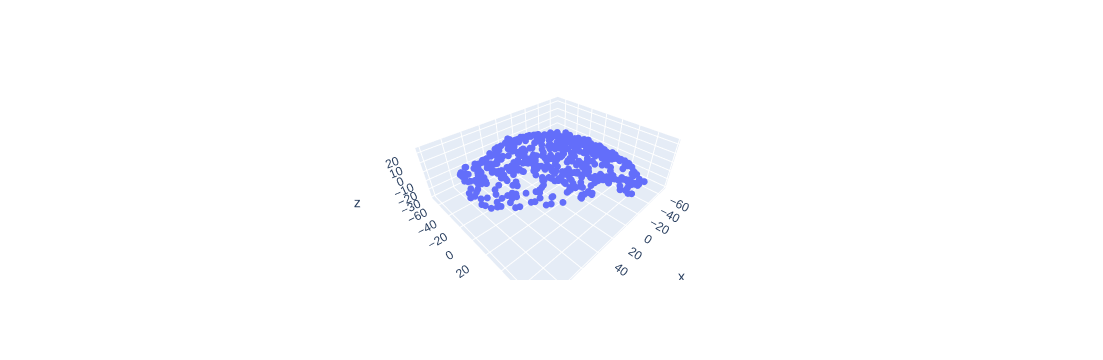

In [5]:
import open3d as o3d
import trimesh

sample_points = np.asarray(trimesh.sample.sample_surface(plot_hull, 512)[0])
fig = px.scatter_3d(x=sample_points[:, 0], y=sample_points[:, 1], z=sample_points[:, 2])
fig.update_traces(marker_size = 4)
fig.show()

In [41]:
import trimesh
plot_id = 46
plot_hull = fin_surf_list[plot_id]
plot_hull = trimesh.smoothing.filter_laplacian(plot_hull, iterations=2)

def plot_mesh(plot_hull):
    # plot_hull = fin_surf_list[mesh_id]
    
    tri_points = plot_hull.vertices[plot_hull.faces]
    
    #extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
    Xe = []
    Ye = []
    Ze = []
    for T in tri_points:
        Xe.extend([T[k%3][0] for k in range(4)]+[ None])
        Ye.extend([T[k%3][1] for k in range(4)]+[ None])
        Ze.extend([T[k%3][2] for k in range(4)]+[ None])
        
           
    #define the trace for triangle sides
    fig = go.Figure()
    lines = go.Scatter3d(
                       x=Ze,
                       y=Ye,
                       z=Xe,
                       mode='lines',
                       name='',
                       line=dict(color= 'rgb(70,70,70)', width=1)) 
    
    lighting_effects = dict(ambient=0.4, diffuse=0.5, roughness = 0.9, specular=0.9, fresnel=0.9)
    fig.add_trace(go.Mesh3d(x=plot_hull.vertices[:, 2], y=plot_hull.vertices[:, 1],z=plot_hull.vertices[:, 0], 
                            opacity=0.65, i=plot_hull.faces[:, 2], j=plot_hull.faces[:, 1], k=plot_hull.faces[:, 0],
                             lighting=lighting_effects))
    
    fig.add_trace(lines)
    fig.update_layout(template="plotly")

    return fig

### Registration sequence

In [59]:
from src.utilities.point_cloud_utils import farthest_point_sample

# set parameters
ref_id = 44
target_id = 49
n_points = 128

# smooth and sample reference mesh
ref_mesh_raw = fin_surf_list[ref_id]
ref_vertices = ref_mesh_raw.vertices # set PD zero-point
ref_vertices[:, 0] = ref_vertices[:, 0] - np.min(ref_vertices[:, 0])
ref_mesh_raw.vertices = ref_vertices
ref_mesh = trimesh.smoothing.filter_laplacian(ref_mesh_raw, iterations=2)
ref_points = ref_mesh.vertices

# select key points indices. Use same set throughout for all targets
np.random.seed(234)
ref_key_points, ref_key_indices = farthest_point_sample(ref_points, n_points)

# smooth and sample target mesh
target_mesh_raw = fin_surf_list[target_id]
target_vertices = target_mesh_raw.vertices # set PD zero-point
target_vertices[:, 0] = target_vertices[:, 0] - np.min(target_vertices[:, 0])
target_mesh_raw.vertices = target_vertices
target_mesh = trimesh.smoothing.filter_laplacian(target_mesh_raw, iterations=2)
target_points = target_mesh.vertices

target_key_points, target_key_indices = farthest_point_sample(target_points, n_points)

fig = px.scatter_3d(x=ref_points[:, 2], y=ref_points[:, 1], z=ref_points[:, 0])
fig.add_trace(go.Scatter3d(x=target_points[:, 2], y=target_points[:, 1], z=target_points[:, 0], mode="markers"))
# fig.add_trace(go.Scatter3d(x=ref_key_points[:, 0], y=ref_key_points[:, 1], z=ref_key_points[:, 2], mode="markers"))
# fig.add_trace(go.Scatter3d(x=target_key_points[:, 0], y=target_key_points[:, 1], z=target_key_points[:, 2], mode="markers"))
fig.update_traces(marker_size = 4)
fig.show()

In [60]:
# perform rigid registration on full set of mesh points
from probreg import cpd
from probreg import bcpd

tf_param, _, _ = cpd.registration_cpd(ref_points, target_points, tf_type_name="rigid", update_scale=False)
result_points = ref_points.copy()
result_points = tf_param.transform(result_points)
result_points[:, 0] = result_points[:, 0] - np.min(result_points[:, 0]) # shift to PD origin

fig0 = px.scatter_3d(x=result_points[:, 2], y=result_points[:, 1], z=result_points[:, 0])
fig0.add_trace(go.Scatter3d(x=target_points[:, 2], y=target_points[:, 1], z=target_points[:, 0], mode="markers"))
# fig.add_trace(go.Scatter3d(x=result_points[ref_key_indices, 0], y=result_points[ref_key_indices, 1], z=result_points[ref_key_indices, 2], mode="markers"))
fig0.update_traces(marker_size = 4)
fig0.show()

In [61]:
import trimesh
figure_path = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/figures/reference_based/"


frame_dir = os.path.join(figure_path, f"scatter_", "")
if not os.path.isdir(frame_dir):
    os.makedirs(frame_dir)

angle_vec = np.linspace(1.25*np.pi, 3.25*np.pi, 50)
fig0 = generic_rotating_figure(fig0, angle_vec, frame_dir)#"PuRd")#"Greys")


100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


In [62]:
import copy 
# Generate new, oriented version of reference mesh
ref_mesh_oriented = copy.deepcopy(ref_mesh)
ref_mesh_oriented.vertices = result_points

# get oriented key points
ref_key_points_oriented = result_points[ref_key_indices, :]

In [63]:
import time
# now, non-rigid transformation using down-sampled points for computational ease

start = time.time()
tf_param = bcpd.registration_bcpd(ref_key_points_oriented, target_key_points)#, tol=1e-10, maxiter=500)
print(time.time()-start)
ref_key_points_out = ref_key_points_oriented.copy()
ref_key_points_out = tf_param.transform(ref_key_points_out)

fig = px.scatter_3d(x=ref_key_points_out[:, 0], y=ref_key_points_out[:, 1], z=ref_key_points_out[:, 2])
fig.add_trace(go.Scatter3d(x=target_key_points[:, 0], y=target_key_points[:, 1], z=target_key_points[:, 2], mode="markers"))
fig.update_traces(marker_size = 4)
fig.show()

0.7308928966522217


In [64]:
fig1 = go.Figure()

# fig.add_trace(go.Scatter3d(x=ref_key_points_oriented[:, 2], 
#                            y=ref_key_points_oriented[:, 1], 
#                            z=ref_key_points_oriented[:, 0], mode="markers"))

# fig.add_trace(go.Scatter3d(x=ref_key_points_out[:, 2], 
#                            y=ref_key_points_out[:, 1], 
#                            z=ref_key_points_out[:, 0], mode="markers"))



for i in range(ref_key_points_oriented.shape[0]):
    arr = np.concatenate((ref_key_points_oriented[i, :][np.newaxis, :], ref_key_points_out[i, :][np.newaxis, :]), axis=0)
    fig1.add_trace(go.Scatter3d(x=arr[:, 2], y=arr[:, 1], z=arr[:, 0], line=dict(width=2)))



fig1.update_traces(marker=dict(size=4, opacity=0.75))
fig1.update_layout(scene=dict(
                 aspectmode='data'
         ))
fig.show()

frame_dir = os.path.join(figure_path, "shift_scatter", "")
if not os.path.isdir(frame_dir):
    os.makedirs(frame_dir)

fig1 = generic_rotating_figure(fig1, angle_vec, frame_dir)

100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


In [65]:
# get normal vectors for key points
ref_normals = ref_mesh_oriented.vertex_normals[ref_key_indices, :]

# get displacement vectors
shift_array = ref_key_points_out - ref_key_points_oriented

# get dot products and shift magnitudes
shift_dot_array = np.sum(np.multiply(ref_normals, shift_array), axis=1)
shift_signs = np.sign(shift_dot_array)
shift_mag_array = np.linalg.norm(shift_array, axis=1)

shift_vec = np.multiply(shift_mag_array, shift_signs)

# Quiver plot
ref_norm = ref_key_points / np.max(ref_key_points)
test_mesh = alphashape(ref_norm, 5)
test_mesh.vertices = ref_key_points

test_mesh = trimesh.smoothing.filter_laplacian(test_mesh, iterations=3)

tri_points = test_mesh.vertices[test_mesh.faces]

#extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
Xe = []
Ye = []
Ze = []
for T in tri_points:
    Xe.extend([T[k%3][0] for k in range(4)]+[ None])
    Ye.extend([T[k%3][1] for k in range(4)]+[ None])
    Ze.extend([T[k%3][2] for k in range(4)]+[ None])
    
       
#define the trace for triangle sides
fig = go.Figure()
lines = go.Scatter3d(
                   x=Ze,
                   y=Ye,
                   z=Xe,
                   mode='lines',
                   name='',
                   line=dict(color= 'rgb(70,70,70)', width=1)) 

lighting_effects = dict(ambient=0.4, diffuse=0.5, roughness = 0.9, specular=0.9, fresnel=0.9)
fig.add_trace(go.Mesh3d(x=test_mesh.vertices[:, 2], y=test_mesh.vertices[:, 1],z=test_mesh.vertices[:, 0], 
                        opacity=1, i=test_mesh.faces[:, 2], j=test_mesh.faces[:, 1], k=test_mesh.faces[:, 0], intensity=np.abs(shift_vec),
                         lighting=lighting_effects, colorscale="magma"))

fig.add_trace(lines)
fig.update_layout(template="plotly")

frame_dir = os.path.join(figure_path, "shift_surface", "")
if not os.path.isdir(frame_dir):
    os.makedirs(frame_dir)

fig.show()
fig = generic_rotating_figure(fig, angle_vec, frame_dir)

100%|██████████| 50/50 [02:15<00:00,  2.70s/it]


Well, that worked! The issue, though is that I cannot represent the shift vectors as a single feature vectors. One simple way that I can think of to condense this info is to just take the shift magnitude, combined with a sign that indicates contraction or expansion relative to surface normal. This will destroy information, but such is life

In [86]:
# get normal vectors for key points
ref_normals = -ref_mesh_oriented.vertex_normals[ref_key_indices, :]

# get displacement vectors
shift_array = ref_key_points_out - ref_key_points_oriented

# get dot products and shift magnitudes
shift_dot_array = np.sum(np.multiply(ref_normals, shift_array), axis=1)
shift_signs = np.sign(shift_dot_array)
shift_mag_array = np.linalg.norm(shift_array, axis=1)

shift_vec = np.multiply(shift_mag_array, shift_signs)

### The pieces look alright. Let's try putting it all together

In [87]:
# extract smoothed reference mesh and keypoints
from src.utilities.point_cloud_utils import farthest_point_sample

# set parameters
ref_id = 30
target_id = 49
n_points = 128

# smooth and sample reference mesh
ref_mesh_raw = fin_surf_list[ref_id]
ref_vertices = ref_mesh_raw.vertices 
# set PD zero-point
ref_vertices[:, 0] = ref_vertices[:, 0] - np.min(ref_vertices[:, 0])
ref_mesh_raw.vertices = ref_vertices
ref_mesh = trimesh.smoothing.filter_laplacian(ref_mesh_raw, iterations=2)
ref_points = ref_mesh.vertices

# select key points indices. Use same set throughout for all targets
np.random.seed(234)
ref_key_points, ref_key_indices = farthest_point_sample(ref_points, n_points)

In [99]:
# iterate through mess list and calculate shift vectors for each
shift_vec_array = np.empty((n_points, 3, len(fin_surf_list)))
shift_vec_array [:] = np.nan
shift_scalar_array = np.empty((len(fin_surf_list), n_points))
shift_scalar_array[:] = np.nan

for target_id in tqdm(range(len(fin_surf_list))):

    # smooth and sample target mesh
    target_mesh_raw = fin_surf_list[target_id]
    
    if "vertices" in dir(target_mesh_raw):# set PD zero-point
        target_vertices = target_mesh_raw.vertices
        target_vertices[:, 0] = target_vertices[:, 0] - np.min(target_vertices[:, 0])
        target_mesh_raw.vertices = target_vertices
        target_mesh = trimesh.smoothing.filter_laplacian(target_mesh_raw, iterations=2)
        target_points = target_mesh.vertices
        
        target_key_points, target_key_indices = farthest_point_sample(target_points, n_points)
        
        # perform non-rigid alignment
        tf_param = bcpd.registration_bcpd(ref_key_points, target_key_points)#, tol=1e-10, maxiter=500)
        ref_key_points_out = ref_key_points.copy()
        ref_key_points_out = tf_param.transform(ref_key_points_out)
        
        # calculate shift metrics
        ref_normals = -ref_mesh.vertex_normals[ref_key_indices, :]
        
        # get displacement vectors
        shift_array = ref_key_points_out - ref_key_points
        
        # get dot products and shift magnitudes
        shift_dot_array = np.sum(np.multiply(ref_normals, shift_array), axis=1)
        shift_signs = np.sign(shift_dot_array)
        shift_mag_array = np.linalg.norm(shift_array, axis=1)
        
        shift_vec = np.multiply(shift_mag_array, shift_signs)
        
        # store
        shift_vec_array[:, :, target_id] = shift_array
        shift_scalar_array[target_id, :] = shift_vec

100%|██████████| 93/93 [01:36<00:00,  1.03s/it]


In [125]:
import umap.umap_ as umap
reducer = umap.UMAP(n_components=3)
nan_ft = ~np.isnan(shift_scalar_array[:, 0])
shift_scaled = np.divide(shift_scalar_array, np.std(shift_scalar_array, axis=1)[:, np.newaxis])
embedding = reducer.fit_transform(shift_scaled[nan_ft,:])

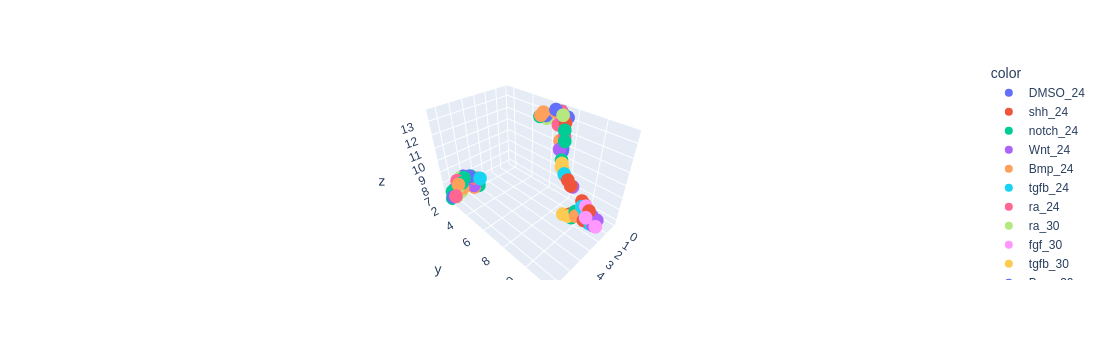

In [138]:
fig = px.scatter_3d(x=embedding[:, 0], y=embedding[:, 1], z=embedding[:, 2], color=fin_stats_df.loc[nan_ft, "chem_i"])
fig.show()

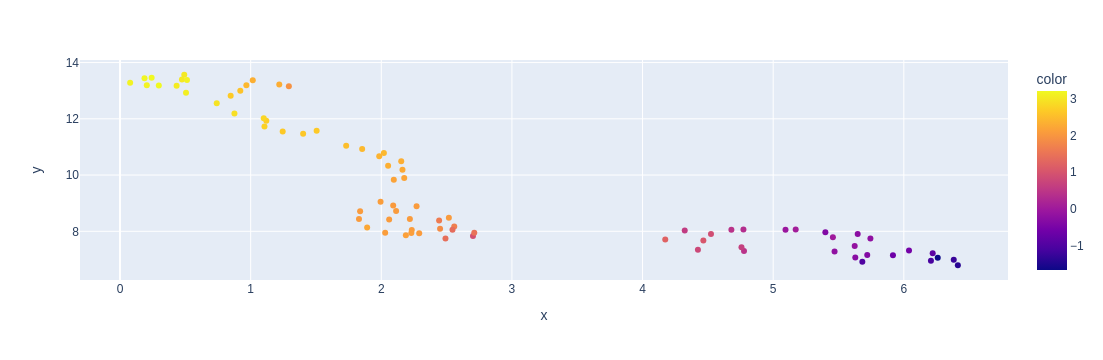

In [133]:
keep_indices = np.where(nan_ft)[0]
fig = px.scatter(x=embedding[:, 0], y=embedding[:,2], color=np.mean(shift_scaled[nan_ft, :], axis=1),
                hover_data=[np.arange(embedding.shape[0])])#color=fin_stats_df.loc[nan_ft, "estimated_stage_hpf"])
fig.show()

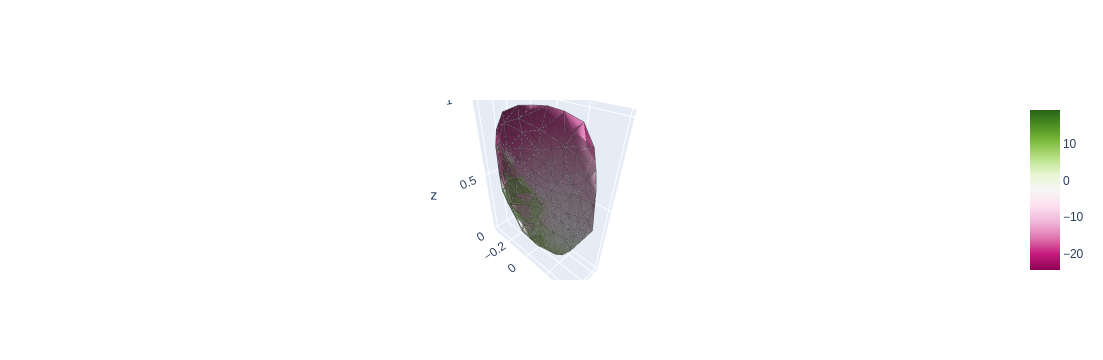

In [155]:
ref_points = ref_key_points / np.max(ref_key_points)
test_mesh = alphashape(ref_points, 5)

target_id = -4
shift_scalars = shift_scalar_array[target_id, :]

tri_points = test_mesh.vertices[test_mesh.faces]

#extract the lists of x, y, z coordinates of the triangle vertices and connect them by a line
Xe = []
Ye = []
Ze = []
for T in tri_points:
    Xe.extend([T[k%3][0] for k in range(4)]+[ None])
    Ye.extend([T[k%3][1] for k in range(4)]+[ None])
    Ze.extend([T[k%3][2] for k in range(4)]+[ None])
    
       
#define the trace for triangle sides
fig = go.Figure()
lines = go.Scatter3d(
                   x=Ze,
                   y=Ye,
                   z=Xe,
                   mode='lines',
                   name='',
                   line=dict(color= 'rgb(70,70,70)', width=1)) 

lighting_effects = dict(ambient=0.4, diffuse=0.5, roughness = 0.9, specular=0.9, fresnel=0.9)
fig.add_trace(go.Mesh3d(x=test_mesh.vertices[:, 2], y=test_mesh.vertices[:, 1],z=test_mesh.vertices[:, 0], 
                        opacity=0.65, i=test_mesh.faces[:, 2], j=test_mesh.faces[:, 1], k=test_mesh.faces[:, 0], intensity=shift_scalars,
                         lighting=lighting_effects))

fig.add_trace(lines)
fig.update_layout(template="plotly")

In [154]:
np.nansum(shift_scalar_array, axis=1)

array([ 5082.36006107,  5537.64170353,  1073.50136787,  5707.90161602,
        5031.70871116,  6691.15837626,     0.        ,  4831.13351032,
       -1257.34676252,     0.        ,  7088.98154547,  1690.97188156,
        6853.23901309,  5000.59277777,  6711.77638292,  7232.2324377 ,
        1719.34021469,     0.        ,  4889.15436329,  6997.94575446,
           0.        ,  2047.40271315,  -120.52504704,  6826.16271447,
        1496.92699471,  2761.06480125,  6462.7188996 ,   694.14959556,
        5084.10814753,  4154.51417054,   146.4095056 ,  7548.99576569,
        5194.22041717,  5404.10341056,  5100.91404501,  5272.17062634,
        7354.65282725,  -104.5789355 ,  6534.66022371,  4835.51548328,
        6605.97920852,  4940.95511857,  2487.57986626,   323.73024915,
        4903.20668784,  4954.11148833,  -149.35934274,  4473.05049592,
       -2667.06050613,  5765.8913695 ,  6375.12302816,     0.        ,
        -516.86269815,  -681.58583278,     0.        ,  5417.82464529,
      

In [156]:
dir(test_mesh)

['__abstractmethods__',
 '__add__',
 '__annotations__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_cache',
 '_data',
 '_visual',
 'apply_obb',
 'apply_scale',
 'apply_transform',
 'apply_translation',
 'area',
 'area_faces',
 'as_open3d',
 'body_count',
 'bounding_box',
 'bounding_box_oriented',
 'bounding_cylinder',
 'bounding_primitive',
 'bounding_sphere',
 'bounds',
 'center_mass',
 'centroid',
 'compute_stable_poses',
 'contains',
 'convert_units',
 'convex_decomposition',
 'convex_hull',
 'copy',
 'density',
 'difference',
 'edges',
 'edges_face',
 'edges_sorted',
 'edges_sorted_tree',
